# Back Propagation

Here is an implementation of the basic back propagation algorithm. This is meant for educational purposes and should not be used in any production environment.

In this notebook, we will implement our back propagation algorithm using gradient descent and Relu non-linearities through a small network. We will also test our back propagation implementation against a simple problem of approximating mathematical functions.

I will not explain in detail the mathematics and reasoning of the implementation, but will link to external sources that do a sufficient job at doing so. [Here](http://neuralnetworksanddeeplearning.com/chap2.html) is a good place to start for getting a foundation of back propagation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

All the models to learn in this network will take 2 inputs and give 1 output. The output is a classification variable that can take on a value between 0 and 1. Values closer to 0 indicate preference for class 0 while values for class 1 prefer class 1.

We will define 3 functions that our neural networks should learn after training:

## Model 1: Inside of Ellipsis

In [2]:
num_points = 10000

In [3]:
def create_ellipse_func(a, b):
    def ellipse_func(x, y):
        return 1 if ((x*x) / (a*a) + (y*y) / (b*b)) <= 1 else 0

    return ellipse_func


In [4]:
model1_func = create_ellipse_func(2.0, 4.0)
model1_points = 8 * np.random.rand(2, num_points) - 4
model1_categories = np.apply_along_axis(lambda x: model1_func(x[0], x[1]), axis=0, arr=model1_points)

split_mask = np.random.rand(num_points) <= 0.6

model1_training = model1_points[:, split_mask]
model1_training_categories = model1_categories[split_mask]

model1_test = model1_points[:, ~split_mask]
model1_test_categories = model1_categories[~split_mask]

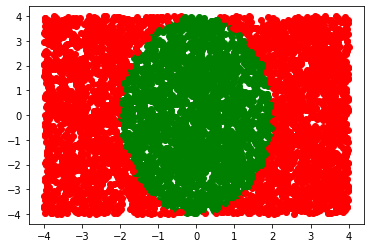

In [5]:
# Let's make a plot to see where the ellipse is being drawn.

for i in range(len(model1_training_categories)):
    point = model1_training[:, i]
    category = model1_training_categories[i]
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

## Model 2: Guassian

In [5]:
def create_gaussian_curve(mean, variance, delta=0.2):
    std = math.sqrt(variance)
    normalize = 1 / (std * math.sqrt(2 * 3.14159))

    def gaussian_curve(x, y):
        term = (x - mean) / std
        expected = normalize * np.exp(-1/2 * term * term)
        return 1 if abs(expected - y) <= delta else 0
    
    return gaussian_curve


In [6]:
model2_func = create_gaussian_curve(0.0, 0.05)
model2_points = np.random.rand(2, num_points) * 4 - 2
model2_categories = np.apply_along_axis(lambda x: model2_func(x[0], x[1]), axis=0, arr=model2_points)

split_mask = np.random.rand(num_points) <= 0.6

model2_training = model2_points[:, split_mask]
model2_training_categories = model2_categories[split_mask]

model2_test = model2_points[:, ~split_mask]
model2_test_categories = model2_categories[~split_mask]

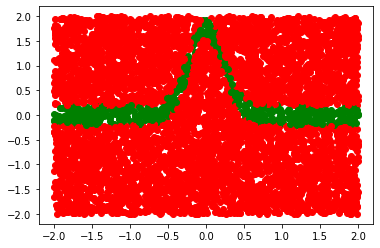

In [7]:
# Let's make a plot to see where the gaussian curve is being drawn.

for i in range(len(model2_training_categories)):
    point = model2_training[:, i]
    category = model2_training_categories[i]
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

## Feed Forward Network

We will design a simple feed-forward network with relu activation.

### Activation Functions

In [8]:
def relu(X):
    mask = X >= 0
    return X * mask
    

In [9]:
def relu_deriv(X):
    return (X >= 0).astype(float)


In [10]:
def sigmoid(X):
    return 1. / (1 + np.exp(-X))


In [11]:
def sigmoid_deriv(X):
    sig = sigmoid(X)
    return sig * (1 - sig)


### Loss Functions

In [12]:
def binary_cross_entropy_loss(output, expected):
    # Note that this function will throw errors if any of the output
    # values are 0 or 1 exactly.
    m = output.shape[1]

    # Offset the output if there are any values exactly equal to
    # zero or one to avoid log(0).
    zero_correct = (output == 0).astype(float) * 1e-40 
    one_correct = (output == 1).astype(float) * (-1e-40)
    output = output + zero_correct + one_correct

    return np.sum((expected * -np.log(output)) + (1 - expected) * -np.log(1 - output)) / m


In [13]:
def binary_cross_entropy_loss_grad(output, expected):
    # Note that this function will throw errors if any output is 0.
    m = output.shape[1]

    zero_correct = (output == 0).astype(float) * 1e-40
    one_correct = (output == 1).astype(float) * (-1e-40)
    output = output + zero_correct + one_correct

    return (1. / m) * ((expected / output) - (1 - expected) / (1 - output))


### Defining the Model

In [14]:
# Note: When initializing the layers, we will assume that the output
# layer is always a single output through a sigmoid activation.
def xavier_initialization(input_size, layer_sizes):
    layers = []
    
    prev_layer_size = input_size

    for size in layer_sizes:
        normalize = 1. / math.sqrt(prev_layer_size)
        weights = np.random.randn(size, prev_layer_size) * normalize
        biases = np.random.randn(size, 1) * normalize
        layers.append((weights, biases))

        prev_layer_size = size
        
    # Add a final output layer for sigmoid activation.
    weights = np.random.randn(1, prev_layer_size)
    biases = np.random.randn(1, 1)
    layers.append((weights, biases))
    
    return layers
    

In [15]:
def forward(model, X):
    Y = X

    linear_outputs = []
    outputs = []

    for (i, (weights, biases)) in enumerate(model['layers'][0:-1]):
        Y = np.dot(weights, Y) + biases
        linear_outputs.append(Y)

        Y = relu(Y)
        outputs.append(Y)
        

    # Note: Last layer is processed by sigmoid activation.
    weights, biases = model['layers'][-1]

    Y = np.dot(weights, Y) + biases
    linear_outputs.append(Y)

    Y = sigmoid(Y)
    outputs.append(Y)

    # Save the results of the forward pass so we can do a backward
    # pass on them later.
    if 'no_grad' not in model or not model['no_grad']:
        model['linear_outputs'] = linear_outputs
        model['input'] = X
        model['outputs'] = outputs
        model['result'] = Y

    return Y
 

In [16]:
def loss(model, expected):
    # Note: We are assuming the model has already gone through a
    # forward pass.
    result = model['result']
    loss = binary_cross_entropy_loss(result, expected)
    return loss


In [17]:
def backward(model, expected):
    # Note: We are assuming the model has already gone through a
    # forward pass.

    layers = model['layers']
    linear_outputs = model['linear_outputs']
    outputs = model['outputs']
    X = model['input']
    result = model['result']

    L = len(layers)
    m = result.shape[1] # Number of samples.

    # Note: We can have multiple samples in the outputs, so we
    # will end up with a gradient per sample.
    output_prev_layer = X if len(outputs) <= 1 else outputs[-2]
    loss_grad = binary_cross_entropy_loss_grad(result, expected)
    error_last_layer = loss_grad * sigmoid_deriv(linear_outputs[-1])
    bias_grad_last_layer = np.sum(error_last_layer, axis=1).reshape(-1, 1) / m
    weights_grad_last_layer = np.dot(error_last_layer, output_prev_layer.T) / m # outer product
    grad_last_layer = (weights_grad_last_layer, bias_grad_last_layer)

    errors = [error_last_layer]
    grads = [grad_last_layer]
    
    # Enumerate layers in reverse order to compute errors
    # and gradients.
    for i in range(L - 2, -1, -1):
        linear_output = linear_outputs[i]
        output_prev_layer = X if i == 0 else outputs[i-1]
        error_next_layer = errors[-1]
        weights_next_layer, bias_next_layer = layers[i+1]

        error = np.dot(weights_next_layer.T, error_next_layer) * sigmoid_deriv(linear_output)
        bias_grad = np.sum(error, axis=1).reshape(-1, 1) / m
        weights_grad = np.dot(error, output_prev_layer.T) / m
        
        errors.append(error)
        grads.append((weights_grad, bias_grad))
        
    # Reverse the order of errors and gradients so they go from
    # first layer to last.
    errors.reverse()
    grads.reverse()
    
    if 'no_grad' not in model or not model['no_grad']:
        model['errors'] = errors
        model['grads'] = grads
    
    return grads, errors


In [18]:
def step_SGD(model, lr=0.1):
    # Note: We are assuming the model has already gone
    # through back propagation and all the gradients have
    # been calculated.
    
    new_layers = []

    for (i, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight, grad_bias = model['grads'][i]
        
        weight = weight + (lr * grad_weight)
        bias = bias + (lr * grad_bias)

        model['layers'][i] = (weight, bias)


In [19]:
def grad_on(model):
    if 'no_grad' in model:
        del model['no_grad']

In [20]:
def grad_off(model):
    model['no_grad'] = True


In [21]:
def clear(model):
    """
    Clear any state that has been saved to the model
    during training.
    """
    keys = ['errors', 'grads', 'input', 'linear_outputs', 'loss', 'loss_grads', 'outputs', 'result']
    
    for key in keys:
        if key in model:
            del model[key]
    

In [22]:
def predict(model, X, threshold=0.5):
    should_toggle_no_grad = 'no_grad' in model and model['no_grad']
    
    if should_toggle_no_grad:
        grad_off(model)

    Y = forward(model, X)
    
    if should_toggle_no_grad:
        grad_on(model)

    return (Y >= threshold).astype(float)


## Gradient Checking

In [23]:
def copy(model):
    model = { 'layers': model['layers'] }
    return model
    

In [36]:
def grad_check(model, X, Y, epsilon=1e-5):
    model = copy(model)
    grad_off(model)
    
    # STEP 1: Generate estimates for back propagation
    # using multiple passes of forward propagation.

    grad_estimates = []

    for (l, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight = np.zeros_like(weight)
        for i in range(weight.shape[0]):
            for j in range(weight.shape[1]):
                weight_orig = weight[i, j]

                # Calculate loss with up weight.
                weight_up = weight[i, j] + epsilon
                model['layers'][l][0][i, j] = weight_up
                Y_hat_up = forward(model, X)
                loss_up = binary_cross_entropy_loss(Y_hat_up, Y)
                
                # Calculate loss with down weight.
                weight_down = weight[i, j] - epsilon
                model['layers'][l][0][i, j] = weight_down
                Y_hat_down = forward(model, X)
                loss_down = binary_cross_entropy_loss(Y_hat_down, Y)
                
                # Record estimated gradient.
                grad_weight[i, j] = (loss_up - loss_down) / (2 * epsilon)
                
                # Reset original weight.
                model['layers'][l][0][i, j] = weight_orig
                


        grad_bias = np.zeros_like(bias)
        for i in range(bias.shape[0]):
            bias_orig = bias[i, 0]

            # Calculate loss with up bias.
            bias_up = bias[i, 0] + epsilon
            model['layers'][l][1][i, 0] = bias_up
            Y_hat_up = forward(model, X)
            loss_up = binary_cross_entropy_loss(Y_hat_up, Y)
                
            # Calculate loss with down bias.
            bias_down = bias[i, 0] - epsilon
            model['layers'][l][1][i, 0] = bias_down
            Y_hat_down = forward(model, X)
            loss_down = binary_cross_entropy_loss(Y_hat_down, Y)
                
            # Record estimated gradient.
            grad_bias[i, 0] = (loss_up - loss_down) / (2 * epsilon)
            
            # Reset original bias.
            model['layers'][l][1][i, 0] = bias_orig
        
        grad_estimates.append((grad_weight, grad_bias))

    grad_on(model)
    
    # STEP 2: Generate the actual gradients using back propagation.
    forward(model, X)
    backward(model, Y)
    
    # STEP 3: Figure out the difference between the estimates and
    # actual gradients.
    error = 0
    num_params = 0

    for (i, grad) in enumerate(model['grads']):
        grad_weight, grad_bias = grad
        grad_weight_hat, grad_bias_hat = grad_estimates[i]
        
        weight_errors_sqrt = grad_weight - grad_weight_hat
        bias_errors_sqrt = grad_bias - grad_bias_hat
        
        weight_errors = weight_errors_sqrt * weight_errors_sqrt
        bias_errors = bias_errors_sqrt * bias_errors_sqrt

        error += np.sum(weight_errors)
        error += np.sum(bias_errors)
        
        num_params += np.prod(grad_weight.shape)
        num_params += np.prod(grad_bias.shape)

    return error / num_params


## Creating and Training the Model

### Model 1

In [37]:
model1 = { 'layers': xavier_initialization(input_size=2, layer_sizes=[3, 4]) }


In [38]:
X = model1_training[:, :2]
Y = model1_training_categories[:2]

grad_check_errors = []

epochs = 100000
batch_size = 1
n = X.shape[1]

model1_train_errors = []
model1_test_errors = []

for i in range(epochs):
    for (batch_i, batch_start) in enumerate(range(0, n, batch_size)):
        batch_X = X[:, batch_i:min(n, batch_start+batch_size)]
        batch_Y = Y[batch_i:min(n, batch_start+batch_size)]

        forward(model1, batch_X)
        backward(model1, batch_Y)
        step_SGD(model1, lr=0.01)

    # Turn off gradient checking while we calculate training
    # and test loss.
    grad_off(model1)

    if i % 10 == 0:
        train_output = forward(model1, X)
        train_error = binary_cross_entropy_loss(train_output, Y)

        test_output = forward(model1, model1_test)
        test_error = binary_cross_entropy_loss(test_output, model1_test_categories)
        
        model1_train_errors.append(train_error)
        model1_test_errors.append(test_error)

        if i % 100 == 0:
            grad_check_error = grad_check(model1, X, Y)
            print(f'Epoch {i + 1}')
            print(f'Train Error {train_error}')
            print(f'Grad Checking', grad_check_error)
            print('')

            grad_check_errors.append(grad_check_error)
    
    # Turn gradient checking back on before we start a new epoch.
    grad_on(model1)


Epoch 1
Train Error 0.05344162475007194
Grad Checking 0.00015011045921489805

Epoch 101
Train Error 0.04691867486113015
Grad Checking 0.00011451148809936109

Epoch 201
Train Error 0.041850994384758713
Grad Checking 9.03224525021392e-05

Epoch 301
Train Error 0.03779711368232331
Grad Checking 7.309721276206352e-05

Epoch 401
Train Error 0.03440204730389388
Grad Checking 7.566274953051839e-05

Epoch 501
Train Error 0.031211821487704364
Grad Checking 6.297684591981728e-05

Epoch 601
Train Error 0.028541541865281905
Grad Checking 5.32453146225639e-05

Epoch 701
Train Error 0.026273789773978193
Grad Checking 4.560932481674368e-05

Epoch 801
Train Error 0.02432420581841861
Grad Checking 3.950338830147485e-05

Epoch 901
Train Error 0.022630552960128305
Grad Checking 3.454206362077273e-05

Epoch 1001
Train Error 0.021145874550084088
Grad Checking 3.0454869345662688e-05

Epoch 1101
Train Error 0.01983405588498812
Grad Checking 2.7047219708606564e-05

Epoch 1201
Train Error 0.018666854630498674


Epoch 10101
Train Error 0.002521514995367704
Grad Checking 6.14630399812053e-07

Epoch 10201
Train Error 0.002494228508944832
Grad Checking 6.025367439703949e-07

Epoch 10301
Train Error 0.0024674772407444184
Grad Checking 5.907863277685975e-07

Epoch 10401
Train Error 0.002441246060252344
Grad Checking 5.793664690828567e-07

Epoch 10501
Train Error 0.0024155203939020585
Grad Checking 5.682650633707755e-07

Epoch 10601
Train Error 0.002390286199884452
Grad Checking 5.574705472947742e-07

Epoch 10701
Train Error 0.002365529944305711
Grad Checking 5.469718750139152e-07

Epoch 10801
Train Error 0.002341238578610284
Grad Checking 5.367584890510319e-07

Epoch 10901
Train Error 0.002317399518191698
Grad Checking 5.268202961196884e-07

Epoch 11001
Train Error 0.002294000622118832
Grad Checking 5.171476383633405e-07

Epoch 11101
Train Error 0.0022710301739112685
Grad Checking 5.077312766362729e-07

Epoch 11201
Train Error 0.0022484768633002825
Grad Checking 4.985623662913728e-07

Epoch 11301
T

Epoch 20101
Train Error 0.0011580121722334989
Grad Checking 1.4853879334050904e-07

Epoch 20201
Train Error 0.0011514070821390659
Grad Checking 1.4699674788197045e-07

Epoch 20301
Train Error 0.00114487062989374
Grad Checking 1.454778879548281e-07

Epoch 20401
Train Error 0.0011384017849168644
Grad Checking 1.4398175721699787e-07

Epoch 20501
Train Error 0.0011319995368261869
Grad Checking 1.4250791169211434e-07

Epoch 20601
Train Error 0.0011256628949497575
Grad Checking 1.4105591781164693e-07

Epoch 20701
Train Error 0.0011193908878521799
Grad Checking 1.3962535238530466e-07

Epoch 20801
Train Error 0.0011131825628743796
Grad Checking 1.3821580155938958e-07

Epoch 20901
Train Error 0.0011070369856864433
Grad Checking 1.3682686290302793e-07

Epoch 21001
Train Error 0.0011009532398532477
Grad Checking 1.3545814231574173e-07

Epoch 21101
Train Error 0.0010949304264119292
Grad Checking 1.3410925501124113e-07

Epoch 21201
Train Error 0.0010889676634613622
Grad Checking 1.327798258262719e-

Epoch 30301
Train Error 0.0007190232301471846
Grad Checking 6.225414383453889e-08

Epoch 30401
Train Error 0.0007162603831388217
Grad Checking 6.18181627874436e-08

Epoch 30501
Train Error 0.0007135169525062403
Grad Checking 6.138661328077742e-08

Epoch 30601
Train Error 0.0007107927407870529
Grad Checking 6.095943604388519e-08

Epoch 30701
Train Error 0.0007080875531434142
Grad Checking 6.053657360279115e-08

Epoch 30801
Train Error 0.0007054011973181818
Grad Checking 6.011796856213135e-08

Epoch 30901
Train Error 0.0007027334835933011
Grad Checking 5.970356529279135e-08

Epoch 31001
Train Error 0.0007000842247485266
Grad Checking 5.9293308254305747e-08

Epoch 31101
Train Error 0.0006974532360202571
Grad Checking 5.888714348004e-08

Epoch 31201
Train Error 0.0006948403350625401
Grad Checking 5.8485017147161327e-08

Epoch 31301
Train Error 0.0006922453419073005
Grad Checking 5.808687681265002e-08

Epoch 31401
Train Error 0.0006896680789267395
Grad Checking 5.769267095253097e-08

Epoch 

Epoch 40301
Train Error 0.0005147373199958692
Grad Checking 3.3811642829867266e-08

Epoch 40401
Train Error 0.0005132406871464904
Grad Checking 3.3632217920277236e-08

Epoch 40501
Train Error 0.000511752036608756
Grad Checking 3.345417671672241e-08

Epoch 40601
Train Error 0.0005102713067010545
Grad Checking 3.3277505521871345e-08

Epoch 40701
Train Error 0.000508798436365076
Grad Checking 3.3102190588778096e-08

Epoch 40801
Train Error 0.0005073333651581327
Grad Checking 3.292821819377591e-08

Epoch 40901
Train Error 0.0005058760332450886
Grad Checking 3.275557479787711e-08

Epoch 41001
Train Error 0.0005044263813915128
Grad Checking 3.2584247158175216e-08

Epoch 41101
Train Error 0.000502984350955499
Grad Checking 3.241422225178597e-08

Epoch 41201
Train Error 0.000501549883880986
Grad Checking 3.224548689126389e-08

Epoch 41301
Train Error 0.000500122922690023
Grad Checking 3.207802859459627e-08

Epoch 41401
Train Error 0.0004987034104761444
Grad Checking 3.191183413250546e-08

Epoc

Epoch 50501
Train Error 0.00039473374327853847
Grad Checking 2.0811473079518102e-08

Epoch 50601
Train Error 0.00039381507089608777
Grad Checking 2.0722956568085634e-08

Epoch 50701
Train Error 0.00039290033007007626
Grad Checking 2.0634988037556066e-08

Epoch 50801
Train Error 0.0003919894963996743
Grad Checking 2.0547562804068093e-08

Epoch 50901
Train Error 0.00039108254568189985
Grad Checking 2.0460676731159938e-08

Epoch 51001
Train Error 0.0003901794539101709
Grad Checking 2.0374325152738763e-08

Epoch 51101
Train Error 0.0003892801972720812
Grad Checking 2.028850389991974e-08

Epoch 51201
Train Error 0.0003883847521473977
Grad Checking 2.0203208917452102e-08

Epoch 51301
Train Error 0.00038749309510628037
Grad Checking 2.0118435755090623e-08

Epoch 51401
Train Error 0.00038660520290744626
Grad Checking 2.0034180157327013e-08

Epoch 51501
Train Error 0.00038572105249605633
Grad Checking 1.9950438063877905e-08

Epoch 51601
Train Error 0.00038484062100199105
Grad Checking 1.9867205

Epoch 60501
Train Error 0.0003190333202604769
Grad Checking 1.4095030024215795e-08

Epoch 60601
Train Error 0.0003184127317038094
Grad Checking 1.4044863129269935e-08

Epoch 60701
Train Error 0.00031779436742148455
Grad Checking 1.3994956345708773e-08

Epoch 60801
Train Error 0.00031717821584267884
Grad Checking 1.3945307777603644e-08

Epoch 60901
Train Error 0.00031656426547550565
Grad Checking 1.3895915868817771e-08

Epoch 61001
Train Error 0.0003159525049059591
Grad Checking 1.384677863658601e-08

Epoch 61101
Train Error 0.0003153429227976912
Grad Checking 1.3797894629876407e-08

Epoch 61201
Train Error 0.00031473550789117786
Grad Checking 1.3749261877382704e-08

Epoch 61301
Train Error 0.00031413024900294064
Grad Checking 1.3700878980861121e-08

Epoch 61401
Train Error 0.00031352713502526833
Grad Checking 1.3652743895440595e-08

Epoch 61501
Train Error 0.0003129261549251054
Grad Checking 1.3604855281355544e-08

Epoch 61601
Train Error 0.00031232729774394
Grad Checking 1.35572112532

Epoch 70401
Train Error 0.00026682579321499845
Grad Checking 1.0159754133815554e-08

Epoch 70501
Train Error 0.00026637954317674297
Grad Checking 1.0128630934493249e-08

Epoch 70601
Train Error 0.00026593467060507636
Grad Checking 1.0097646613550426e-08

Epoch 70701
Train Error 0.00026549116932421017
Grad Checking 1.0066800540986484e-08

Epoch 70801
Train Error 0.0002650490331950924
Grad Checking 1.0036091740062628e-08

Epoch 70901
Train Error 0.0002646082561142962
Grad Checking 1.0005519648005028e-08

Epoch 71001
Train Error 0.0002641688320143534
Grad Checking 9.975083167879038e-09

Epoch 71101
Train Error 0.00026373075486308724
Grad Checking 9.94478163837755e-09

Epoch 71201
Train Error 0.0002632940186637234
Grad Checking 9.914614376245605e-09

Epoch 71301
Train Error 0.00026285861745444574
Grad Checking 9.884580467055027e-09

Epoch 71401
Train Error 0.0002624245453080067
Grad Checking 9.854679245984581e-09

Epoch 71501
Train Error 0.0002619917963316721
Grad Checking 9.82490982309655

Epoch 80301
Train Error 0.00022848042696947782
Grad Checking 7.644092373404661e-09

Epoch 80401
Train Error 0.00022814542590987341
Grad Checking 7.623542997374856e-09

Epoch 80501
Train Error 0.00022781133274478397
Grad Checking 7.603074026409153e-09

Epoch 80601
Train Error 0.00022747814389842164
Grad Checking 7.582685287884598e-09

Epoch 80701
Train Error 0.00022714585581333618
Grad Checking 7.562376304071366e-09

Epoch 80801
Train Error 0.00022681446495058168
Grad Checking 7.542146643150973e-09

Epoch 80901
Train Error 0.00022648396778916094
Grad Checking 7.52199593016172e-09

Epoch 81001
Train Error 0.00022615436082646967
Grad Checking 7.501923733802419e-09

Epoch 81101
Train Error 0.00022582564057768565
Grad Checking 7.481929727691947e-09

Epoch 81201
Train Error 0.00022549780357587954
Grad Checking 7.462013408194986e-09

Epoch 81301
Train Error 0.00022517084637195932
Grad Checking 7.442174382908262e-09

Epoch 81401
Train Error 0.00022484476553444804
Grad Checking 7.42241242968095

Epoch 90101
Train Error 0.00019948117651974657
Grad Checking 5.958503326313682e-09

Epoch 90201
Train Error 0.00019922058778643184
Grad Checking 5.944219130986589e-09

Epoch 90301
Train Error 0.00019896062908180743
Grad Checking 5.9299848716448865e-09

Epoch 90401
Train Error 0.00019870129819082682
Grad Checking 5.915800466195909e-09

Epoch 90501
Train Error 0.00019844259290888907
Grad Checking 5.901665529402989e-09

Epoch 90601
Train Error 0.0001981845110415609
Grad Checking 5.887579835729271e-09

Epoch 90701
Train Error 0.00019792705040418807
Grad Checking 5.8735432539504196e-09

Epoch 90801
Train Error 0.0001976702088225618
Grad Checking 5.859555541272242e-09

Epoch 90901
Train Error 0.00019741398413214106
Grad Checking 5.8456164156985745e-09

Epoch 91001
Train Error 0.0001971583741784414
Grad Checking 5.831725708209404e-09

Epoch 91101
Train Error 0.00019690337681675717
Grad Checking 5.817883144070588e-09

Epoch 91201
Train Error 0.00019664898991227274
Grad Checking 5.8040885320565

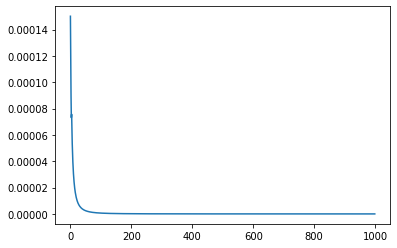

In [39]:
plt.plot(grad_check_errors)

### Model 2

In [47]:
model2 = { 'layers': xavier_initialization(input_size=2, layer_sizes=[3, 4]) }


In [78]:
X = model2_training
Y = model2_training_categories

epochs = 100000
batch_size = 1000
n = model2_training.shape[1]

model2_train_errors = []
model2_test_errors = []

for i in range(epochs):
    for (batch_i, batch_start) in enumerate(range(0, n, batch_size)):
        batch_X = X[:, batch_start:min(n, batch_start+batch_size)]
        batch_Y = Y[batch_start:min(n, batch_start+batch_size)]

        forward(model2, batch_X)
        backward(model2, batch_Y)
        step_SGD(model2, lr=0.01)

    
    # Turn off gradient checking while we calculate training
    # and test loss.
    grad_off(model2)

    if i % 10 == 0:
        train_output = forward(model2, X)
        train_error = binary_cross_entropy_loss(train_output, Y)

        test_output = forward(model2, model2_test)
        test_error = binary_cross_entropy_loss(test_output, model2_test_categories)
        
        model2_train_errors.append(train_error)
        model2_test_errors.append(test_error)

        if i % 100 == 0:
            print(f'Train Error {train_error}')
            
            for weight,_ in model2['layers']:
                max_weight = np.amax(np.abs(weight))
                min_weight = np.amin(np.abs(weight))
                closest_to_inf_weight = max(max_weight, closest_to_inf_weight)
                closest_to_zero_weight = min(min_weight, closest_to_zero_weight)
                
            print(f'Largest Weight: {closest_to_inf_weight}, Smallest Weight: {closest_to_zero_weight}')
    
    # Turn gradient checking back on before we start a new epoch.
    grad_on(model2)


NameError: name 'model2' is not defined

## Viewing the Results

### Model 1

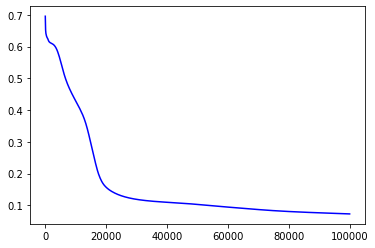

In [41]:
x = [i*100 for i in range(len(model1_train_errors))]

# plt.plot(x, model1_train_errors, 'green')
plt.plot(x, model1_test_errors, 'blue')
plt.show()

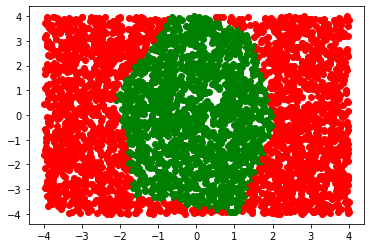

In [42]:
n = model1_test.shape[1]

for i in range(n):
    point = model1_test[:, i].reshape(-1, 1)
    category = predict(model1, point)
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

**NOTE: Notice the sharp edges that define our model for the ellipse. This is likely caused by the fact that we are using a very small neural network to train this model. Since the relu activation function is nearly linear and there are very few layers, the linearities in the learned model are very apparent.**

### Model 2

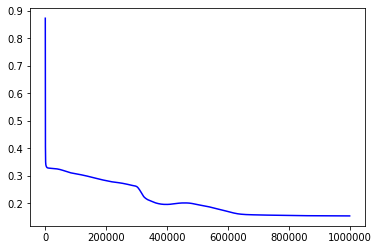

In [49]:
x = [i*100 for i in range(len(model2_train_errors))]

# plt.plot(x, model2_train_errors, 'green')
plt.plot(x, model2_test_errors, 'blue')
plt.show()

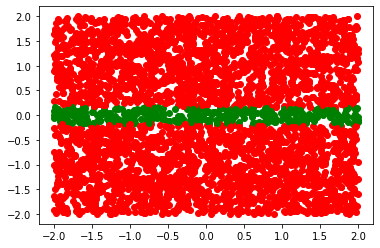

In [50]:
n = model2_test.shape[1]

for i in range(n):
    point = model2_test[:, i].reshape(-1, 1)
    category = predict(model2, point)
    plt.plot(point[0], point[1], 'go' if category == 1 else 'ro')

plt.show()

**NOTE: While our second model did show improvement, it failed to learn the curve of the guassian function. I will continue to explore this more in a separate notebook.**